In [1]:
import gc
import os
import re
import nltk
import spacy
import torch
import pickle
import joblib

import numpy as np
import pandas as pd

from tqdm.auto import tqdm
from datasets import Dataset
from collections import Counter
from nltk.data import load as nltk_load
from nltk.tokenize import PunktSentenceTokenizer
from typing import Callable, List, Tuple

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
# from catboost import CatBoostClassifier, CatBoostRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelWithLMHead, AutoModelForCausalLM

In [63]:
CROSS_ENTROPY = torch.nn.CrossEntropyLoss(reduction='none')
NLTK          = PunktSentenceTokenizer()
DEVICE        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE        = torch.device('cpu')

In [64]:
sent_cut_en = NLTK.tokenize

In [65]:
def gpt2_features(text, tokenizer, model, sent_cut):
    # Tokenize
    input_max_length = tokenizer.model_max_length - 2
    token_ids, offsets = list(), list()
    sentences = sent_cut(text)
    
    for s in sentences:
        tokens = tokenizer.tokenize(s)
        ids = tokenizer.convert_tokens_to_ids(tokens)
        difference = len(token_ids) + len(ids) - input_max_length
        if difference > 0:
            ids = ids[:-difference]
        offsets.append((len(token_ids), len(token_ids) + len(ids)))
        token_ids.extend(ids)
        if difference >= 0:
            break

    input_ids = torch.tensor([tokenizer.bos_token_id] + token_ids).to(DEVICE)
    logits = model(input_ids).logits
    
    # Shift so that n-1 predict n
    shift_logits = logits[:-1].contiguous()
    shift_target = input_ids[1:].contiguous()
    loss = CROSS_ENTROPY(shift_logits, shift_target)

    all_probs = torch.softmax(shift_logits, dim=-1)
    sorted_ids = torch.argsort(all_probs, dim=-1, descending=True)  # stable=True
    expanded_tokens = shift_target.unsqueeze(-1).expand_as(sorted_ids)
    indices = torch.where(sorted_ids == expanded_tokens)
    rank = indices[-1]
    counter = [
        rank < 10,
        (rank >= 10) & (rank < 100),
        (rank >= 100) & (rank < 1000),
        rank >= 1000
    ]
    counter = [c.long().sum(-1).item() for c in counter]


    # compute different-level ppl
    text_ppl = loss.mean().exp().item()
    sent_ppl = list()
    for start, end in offsets:
        nll = loss[start: end].sum() / (end - start)
        sent_ppl.append(nll.exp().item())
        
    max_sent_ppl = max(sent_ppl)
    sent_ppl_avg = sum(sent_ppl) / len(sent_ppl)
    if len(sent_ppl) > 1:
        sent_ppl_std = torch.std(torch.tensor(sent_ppl)).item()
    else:
        sent_ppl_std = 0

    mask = torch.tensor([1] * loss.size(0)).to(DEVICE)
    step_ppl = loss.cumsum(dim=-1).div(mask.cumsum(dim=-1)).exp()
    max_step_ppl = step_ppl.max(dim=-1)[0].item()
    step_ppl_avg = step_ppl.sum(dim=-1).div(loss.size(0)).item()
    if step_ppl.size(0) > 1:
        step_ppl_std = step_ppl.std().item()
    else:
        step_ppl_std = 0
    ppls = [
        text_ppl, max_sent_ppl, sent_ppl_avg, sent_ppl_std,
        max_step_ppl, step_ppl_avg, step_ppl_std
    ]
    return counter, ppls  # type: ignore

In [66]:
cols = [
    'text_ppl', 'max_sent_ppl', 'sent_ppl_avg', 'sent_ppl_std', 'max_step_ppl', 
    'step_ppl_avg', 'step_ppl_std', 'rank_0', 'rank_10', 'rank_100', 'rank_1000'
]

final_cols = [
    'text',  
    'source',
    'prompt_id',
    'text_length' ,
    'word_count',
    'label', 'text_ppl', 'max_sent_ppl', 'sent_ppl_avg', 'sent_ppl_std', 'max_step_ppl', 
    'step_ppl_avg', 'step_ppl_std', 'rank_0', 'rank_10', 'rank_100', 'rank_1000'
]

In [74]:
for i in range(3,4):
    curr_num = i
    train          = pd.read_csv(f'Data/Chunked_Data_1/chunk_{curr_num}.csv')
    train['label'] = np.where(train['source'] == 'Human', 0, 1)
    train          = train.drop_duplicates(subset=['text']).reset_index(drop=True).dropna(subset=['text'])
    train['label'].value_counts()
    models_train_feats = []

    for model in tqdm(['gpt2-large']):
        TOKENIZER_EN = AutoTokenizer.from_pretrained(f'{model}/tokenizer')
        MODEL_EN     = AutoModelForCausalLM.from_pretrained(f'{model}/model').to(DEVICE)
        
        train_ppl_feats  = []
        train_gltr_feats = []
        with torch.no_grad():
            for text in tqdm(train.text.values):
                gltr, ppl = gpt2_features(text, TOKENIZER_EN, MODEL_EN, sent_cut_en)
                train_ppl_feats.append(ppl)
                train_gltr_feats.append(gltr)
                
        X_train = pd.DataFrame(
            np.concatenate((train_ppl_feats, train_gltr_feats), axis=1), 
            columns=[f'{model}-{col}' for col in cols]
        )
        models_train_feats.append(X_train)
        
        del X_train
        del TOKENIZER_EN; del MODEL_EN
        del train_ppl_feats; del train_gltr_feats
        
        gc.collect()
        torch.cuda.empty_cache()
        
    train_feats = pd.concat(models_train_feats, axis=1)
    train_feats = pd.concat([train,train_feats], axis = 1)
    train_feats.to_csv(f"Data/Feature_Extraction/chunk_{curr_num}.csv",index=False)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/494 [00:00<?, ?it/s]

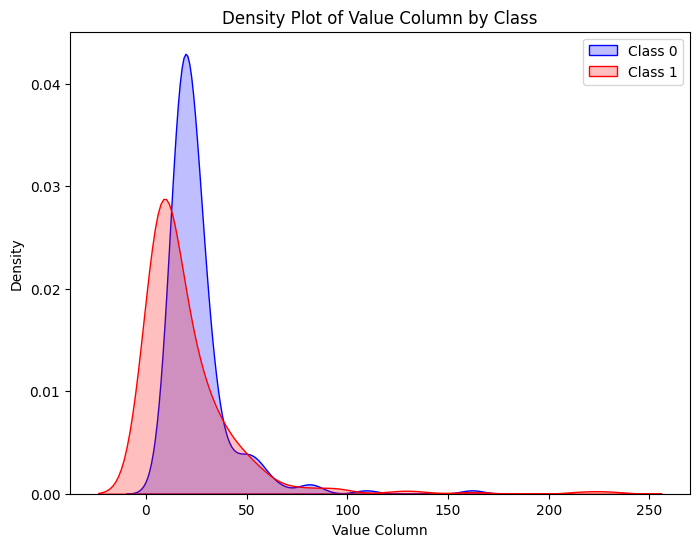

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample DataFrame with 'class' and 'value_column'
# Assume 'class' is the target variable and 'value_column' is the column to plot
# Modify this based on your DataFrame
# train_feats['label'] = np.where(train['source'] == 'Human', 0, 1)
# test is assumed to have 'label' for the class and 'value_column' for the feature

# Example: test dataframe with 'label' for class and 'value_column' for the feature
# test = pd.DataFrame({
#    'label': [0, 1, 0, 1, 0, 1],
#    'value_column': [0.2, 0.8, 0.5, 0.7, 0.3, 0.6]
# })

# Create the density plot
plt.figure(figsize=(8, 6))
sns.kdeplot(data=train_feats[train_feats['label'] == 0], x='gpt2-large-text_ppl', fill=True, label='Class 0', color='blue')
sns.kdeplot(data=train_feats[train_feats['label'] == 1], x='gpt2-large-text_ppl', fill=True, label='Class 1', color='red')

# Add labels and title
plt.title('Density Plot of Value Column by Class')
plt.xlabel('Value Column')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()
